# AI FOR SECURITY

## INTRODUCTION

The Internet of Medical Things (IoMT) has become increasingly vital in healthcare, enabling continuous patient monitoring and automated medical services. However, this connectivity also introduces cybersecurity risks that could compromise patient care and privacy. The CICIoMT2024 dataset, developed by the Canadian Institute for Cybersecurity (CIC), provides a comprehensive benchmark for evaluating IoMT security solutions.

### Dataset Overview
- Contains network traffic from 40 IoMT devices (25 real and 15 simulated)
- Includes traffic across multiple protocols: Wi-Fi, MQTT, and Bluetooth
- Features 18 different types of attacks categorized into:
  - DDoS (Distributed Denial of Service)
  - DoS (Denial of Service)
  - Reconnaissance
  - MQTT-specific attacks
  - Spoofing


### Project Objectives
1. Analyze a subset of the CICIoMT2024 dataset to develop efficient security models
2. Implement and evaluate both supervised and unsupervised learning approaches
3. Compare model performance across different attack categories
4. Identify the most effective model for real-time threat detection in IoMT networks

Our analysis will focus on the trade-off between model complexity and detection accuracy, aiming to provide practical insights for securing healthcare IoT infrastructure.

## Libraries

### Data Manipulation and Analysis

In [19]:
import pandas as pd
import numpy as np

### Data Visualisation

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

### Text Processing

In [21]:
import re

### Machine Learning

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### System/File Operations

In [23]:
import os

## DATASET

### Download Dataset

Create the directory and download the whole CSV dataset through *wget*
```bash
mkdir dataset
cd dataset/ && wget -c -r -np -nH --cut-dirs=3 -R "index.html*" http://205.174.165.80/IOTDataset/CICIoMT2024/Dataset/WiFI_and_MQTT/attacks/CSV/
```

### Analyse Dataset

The dataset consists of network traffic files organized by protocols and different attack types. Due to the diverse distribution of data across files, our first step was to analyze the volume of samples. This initial assessment was crucial as significant imbalances in data volume between attack types or protocols could skew our analysis.

Understanding these distributions allowed us to create a balanced and representative subset of the data for our analysis while ensuring computational efficiency.

#### File Length Analysis

The following code analyzes and visualizes the data distribution across files, implementing our sampling process based on file sizes:

- Files < 20k rows: Retained entirely
- Files 20k-100k rows: Keep 20k rows + 20% of remaining data
- Files > 100k rows: Apply previous rules + 10% of remaining data

This stratified sampling approach helps maintain dataset balance while managing computational resources. The visualization uses color coding (green/orange/red) to highlight these size thresholds.

In [ ]:
def get_color_by_length(length):
    if length < 20000:
        return 'green'
    elif length < 100000:
        return 'orange'
    else:
        return 'red'

def plot_len(name, directory_type="original"):
    """
    Functions to analyze and visualize the distribution of data across files in the dataset:

    get_color_by_length(): Assigns colors based on file size (green: <20k rows, orange: 20k-100k rows, red: >100k rows)

    plot_len(): Creates bar plots showing the number of rows in each CSV file within a directory.
    Parameters:
    - name: Dataset name ('mqtt' or 'wifi')  
    - directory_type: Source directory ('original' or 'subset')

    compare_directories(): Compares data distributions between original and subset directories for a given protocol
    """
    # Base directory selection
    if directory_type.lower() == "original":
        base_dir = 'dataset/original'
        dir_suffix = "_og"
    elif directory_type.lower() == "subset":
        base_dir = 'dataset/subset'
        dir_suffix = ""
    else:
        raise ValueError("directory_type must be either 'original' or 'subset'")
    
    # Construct directory path
    data_dir = os.path.join(base_dir, name + dir_suffix)
    
    # Check if directory exists
    if not os.path.exists(data_dir):
        print(f"Directory not found: {data_dir}")
        return
    
    files = os.listdir(data_dir)
    
    # Dictionary to store file names and their lengths
    file_lengths = {}
    
    # Get length of each CSV file
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(data_dir, file)
            df = pd.read_csv(file_path)
            length = len(df)
            file_lengths[file] = length
 
    if not file_lengths:
        print(f"No CSV files found in {data_dir}")
        return
    
    # Create a bar plot
    plt.figure(figsize=(15, 8))
    
    # Create bars with colors based on length
    bars = plt.bar(file_lengths.keys(), file_lengths.values())
    
    # Set color for each bar based on its height
    if directory_type.lower() == "original":
        for bar in bars:
            bar.set_color(get_color_by_length(bar.get_height()))
    
    # Customize the plot
    plt.title(f'Number of Rows in Each CSV File - {name} Dataset ({directory_type})', pad=20)
    plt.xlabel('File Names')
    plt.ylabel('Number of Rows')
    
    # Add legend
    if directory_type.lower() == "original":
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor='green', label='<20k rows'),
                            plt.Rectangle((0,0),1,1, facecolor='orange', label='20k-100k rows'),
                            plt.Rectangle((0,0),1,1, facecolor='red', label='>100k rows')]
        plt.legend(handles=legend_elements)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'file_lengths_{name}_{directory_type}.png', bbox_inches='tight')
    print(f"\nPlot saved as file_lengths_{name}_{directory_type}.png")
    
    # Display the plot
    plt.show()

def compare_directories(name):
    print(f"\nAnalyzing {name} dataset in both original and subset directories...")
    plot_len(name, "original")
    plot_len(name, "subset")



Plot saved as file_lengths_train_original.png


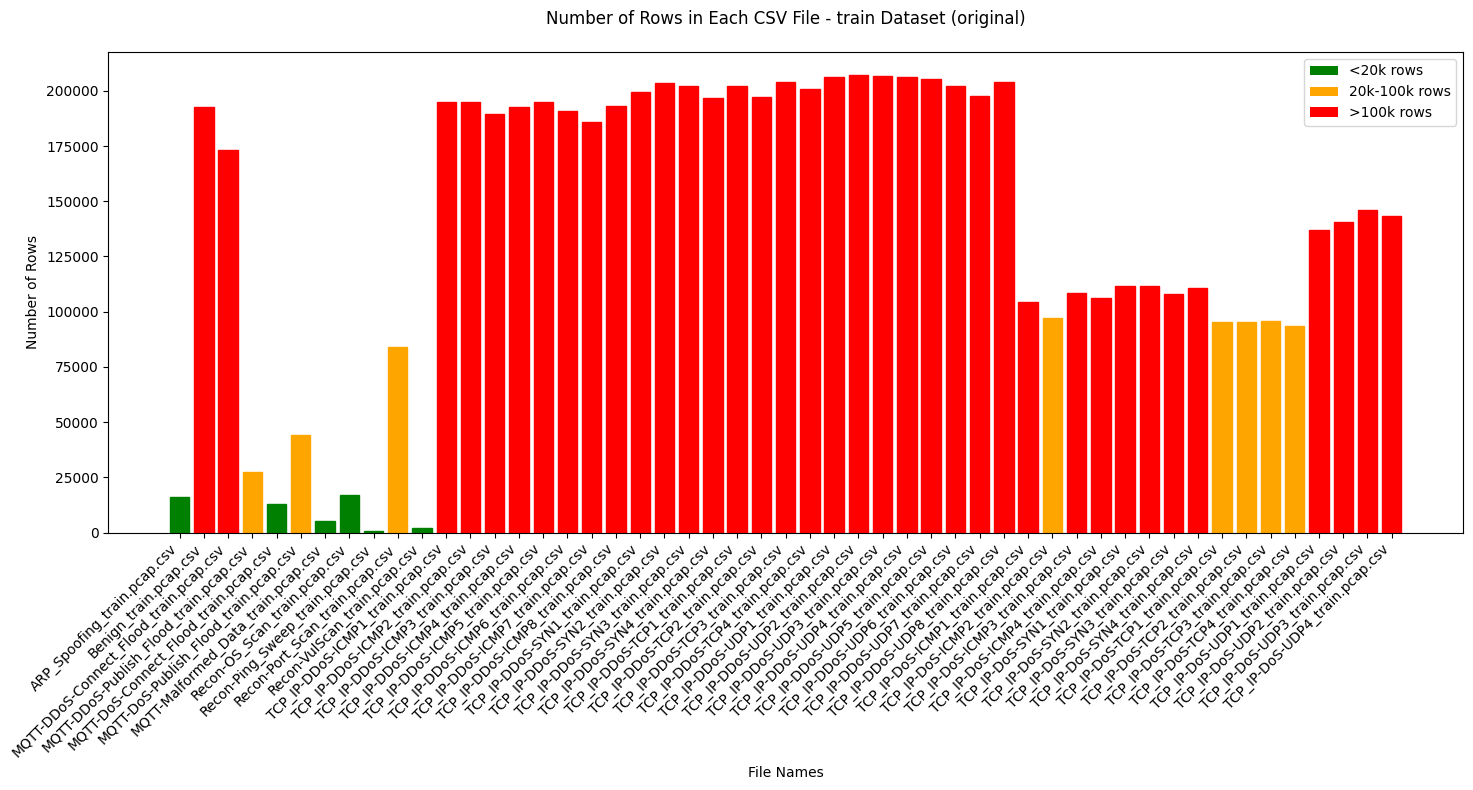


Plot saved as file_lengths_test_original.png


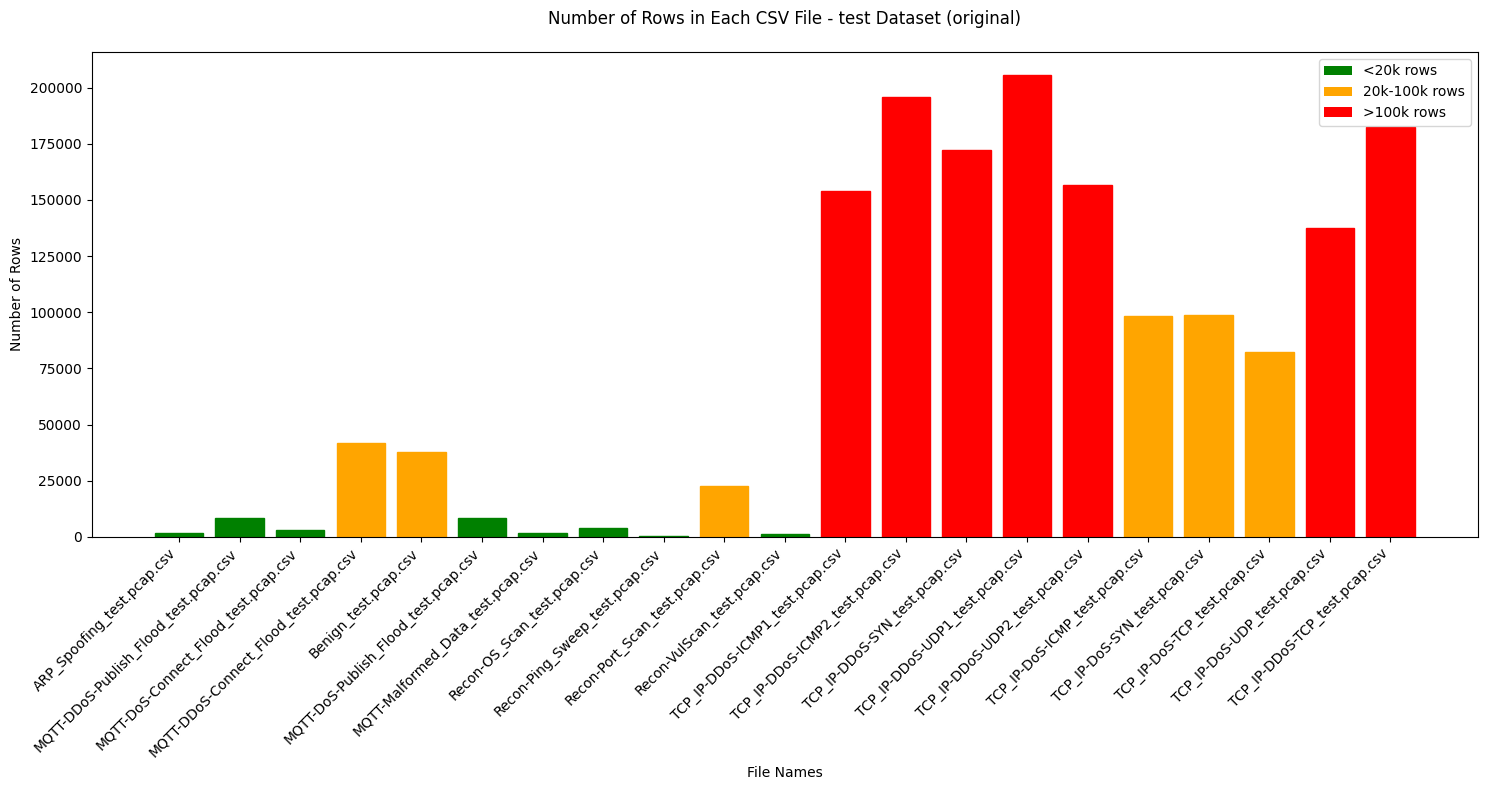

In [18]:
plot_len("train", "original")
plot_len("test", "original")

#### Subset

Create Directory
```bash
mkdir dataset/subset && cd dataset/subset
mkdir train && mkdir test
```

##### Subset Generation 

This code implements our sampling strategy through random sampling, using a fixed random seed for reproducibility. 

For each file, it applies the rules presented before.
The stratified approach maintains data representativeness while reducing volume, with random sampling ensuring unbiased selection across each range.

In [ ]:
RANDOM_SEED = 42

CAP = 20000
FIRST = 0.2
SECOND = 0.1

# List all files in the original dataset directory
original_dir = 'dataset/original'
subset_dir = 'dataset/subset'

def calculate_subset(df):
    total_rows = len(df)
    
    if total_rows < CAP:
        # For files under 20k rows, keep all rows
        return df
    
    elif total_rows < 100000:
        # For files between 20k and 100k:
        # 1. First 20k random rows
        first = df.sample(n=CAP, random_state=RANDOM_SEED)
        
        # 2. 20% of remaining rows
        remaining_rows = df.drop(first.index)
        additional_rows = remaining_rows.sample(frac=FIRST, random_state=RANDOM_SEED)
        
        # Combine both samples
        return pd.concat([first, additional_rows])
    
    else:
        # For files over 100k:
        # 1. First 20k random rows
        first = df.sample(n=CAP, random_state=RANDOM_SEED)
        
        # 2. 20% of next 80k rows
        next_80k = df.drop(first.index).sample(n=(100000-CAP), random_state=RANDOM_SEED)
        twenty_percent_of_80k = next_80k.sample(frac=0.2, random_state=RANDOM_SEED)
        
        # 3. 10% of remaining rows (those above 100k)
        remaining_rows = df.drop(first.index).drop(next_80k.index)
        ten_percent_of_remaining = remaining_rows.sample(frac=0.1, random_state=RANDOM_SEED)
        
        # Combine all samples
        return pd.concat([first, twenty_percent_of_80k, ten_percent_of_remaining])

def subset(name):
    np.random.seed(RANDOM_SEED)
    og_dir = os.path.join(original_dir, name + "_og")
    sub_dir = os.path.join(subset_dir, name)
    
    # Print the directory being processed
    print(f"Processing directory: {og_dir}")
    
    # Make sure the output directory exists
    os.makedirs(sub_dir, exist_ok=True)
    
    # List of all files
    files = os.listdir(og_dir)
    
    for file in files:
        file_path = os.path.join(og_dir, file)
        if os.path.isfile(file_path) and file.endswith('.csv'):
            # Read the CSV file
            df = pd.read_csv(file_path)
            original_size = len(df)
            
            # Calculate subset based on size
            df_subset = calculate_subset(df)
            
            # Save the subset to the new directory
            subset_file_path = os.path.join(sub_dir, file)
            df_subset.to_csv(subset_file_path, index=False)
            
            print_processed_info = lambda file, original_size, subset_size: print(
                f"Processed {file}:\n"
                f"  Original size: {original_size:,} rows\n"
                f"  Subset size: {subset_size:,} rows\n"
                f"  Reduction: {((original_size - subset_size) / original_size * 100):.1f}%\n"
            )
            print_processed_info(file, original_size, len(df_subset))
    
    print(f"Finished processing {name} directory\n")

# Process both train and test datasets
subset("train")
subset("test")

Processing directory: dataset/original/train_og
Finished processing train directory

Processing directory: dataset/original/test_og
Finished processing test directory



In [ ]:
plot_len("test", "subset")
plot_len("train", "subset")

##### Data Merging and Additional Feature Creation
After creating subsets, we merged the files into consolidated train and test datasets, adding two categorical features:
- `category`: Attack classification (DDoS, DoS, etc.)
- `attack`: Specific attack type 

The mapping between filenames and attack types was automated using regex pattern matching. This consolidation maintains attack classification information while simplifying subsequent analysis.

In [24]:
def get_category_and_attack(filename):
    # Dictionary mapping regex patterns to categories and specific attacks
    attack_mapping = {
        r'^Benign': ('BENIGN', '-'),
        r'^ARP_Spoofing': ('SPOOFING', 'ARP Spoofing'),
        r'^Recon-Ping_Sweep': ('RECON', 'Ping Sweep'),
        r'^Recon-VulScan': ('RECON', 'Recon VulScan'),
        r'^Recon-OS_Scan': ('RECON', 'OS Scan'),
        r'^Recon-Port_Scan': ('RECON', 'Port Scan'),
        r'^MQTT-Malformed_Data': ('MQTT', 'Malformed Data'),
        r'^MQTT-DoS-Connect_Flood': ('MQTT', 'DoS Connect Flood'),
        r'^MQTT-DDoS-Publish_Flood': ('MQTT', 'DDoS Publish Flood'),
        r'^MQTT-DoS-Publish_Flood': ('MQTT', 'DoS Publish Flood'),
        r'^MQTT-DDoS-Connect_Flood': ('MQTT', 'DDoS Connect Flood'),
        r'TCP_IP-DoS-TCP': ('DoS', 'DoS TCP'),
        r'TCP_IP-DoS-ICMP': ('DoS', 'DoS ICMP'),
        r'TCP_IP-DoS-SYN': ('DoS', 'DoS SYN'),
        r'TCP_IP-DoS-UDP': ('DoS', 'DoS UDP'),
        r'TCP_IP-DDoS-SYN': ('DDoS', 'DDoS SYN'),
        r'TCP_IP-DDoS-TCP': ('DDoS', 'DDoS TCP'),
        r'TCP_IP-DDoS-ICMP': ('DDoS', 'DDoS ICMP'),
        r'TCP_IP-DDoS-UDP': ('DDoS', 'DDoS UDP')
    }
    
    for pattern, (category, attack) in attack_mapping.items():
        if re.match(pattern, filename):
            return category, attack
            
    return 'UNKNOWN', 'UNKNOWN'

def merge_csv_files(directory, output_file):
    # List to store all dataframes
    dfs = []
    
    # Walk through all files in directory
    files = os.listdir(directory)
    total_files = len(files)
    
    print(f"Processing {total_files} files in {directory}")
    
    for i, filename in enumerate(files, 1):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            
            # Get category and attack type
            category, attack = get_category_and_attack(filename)
            
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Add category and attack columns
            df['category'] = category
            df['attack'] = attack
            
            dfs.append(df)
            
            print(f"Processed file {i}/{total_files}: {filename} - Category: {category}, Attack: {attack}")
    
    # Concatenate all dataframes
    print("\nMerging all dataframes...")
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # Save to file
    print(f"Saving merged dataset to {output_file}")
    merged_df.to_csv(output_file, index=False)
    
    # Print summary
    print("\nSummary of merged dataset:")
    print(f"Total rows: {len(merged_df)}")
    print("\nDistribution of attacks:")
    summary = merged_df.groupby(['category', 'attack']).size().reset_index(name='count')
    summary = summary.sort_values('count', ascending=False)
    print(summary)

# Merge train and test separately
base_dir = 'dataset/subset'
merge_csv_files(os.path.join(base_dir, 'train'), 'merged_train.csv')
merge_csv_files(os.path.join(base_dir, 'test'), 'merged_test.csv')

Processing 51 files in dataset/subset/train
Processed file 1/51: ARP_Spoofing_train.pcap.csv - Category: SPOOFING, Attack: ARP Spoofing
Processed file 2/51: Benign_train.pcap.csv - Category: BENIGN, Attack: -
Processed file 3/51: MQTT-DDoS-Connect_Flood_train.pcap.csv - Category: MQTT, Attack: DDoS Connect Flood
Processed file 4/51: MQTT-DDoS-Publish_Flood_train.pcap.csv - Category: MQTT, Attack: DDoS Publish Flood
Processed file 5/51: MQTT-DoS-Connect_Flood_train.pcap.csv - Category: MQTT, Attack: DoS Connect Flood
Processed file 6/51: MQTT-DoS-Publish_Flood_train.pcap.csv - Category: MQTT, Attack: DoS Publish Flood
Processed file 7/51: MQTT-Malformed_Data_train.pcap.csv - Category: MQTT, Attack: Malformed Data
Processed file 8/51: Recon-OS_Scan_train.pcap.csv - Category: RECON, Attack: OS Scan
Processed file 9/51: Recon-Ping_Sweep_train.pcap.csv - Category: RECON, Attack: Ping Sweep
Processed file 10/51: Recon-Port_Scan_train.pcap.csv - Category: RECON, Attack: Port Scan
Processed fi

##### Plotting Features
This code performs statistical analysis on the merged dataset to uncover feature relationships and characteristics. Through correlation matrices, variance metrics, and zero/missing value analysis, it reveals redundant features and quality issues that inform feature selection and preprocessing decisions.

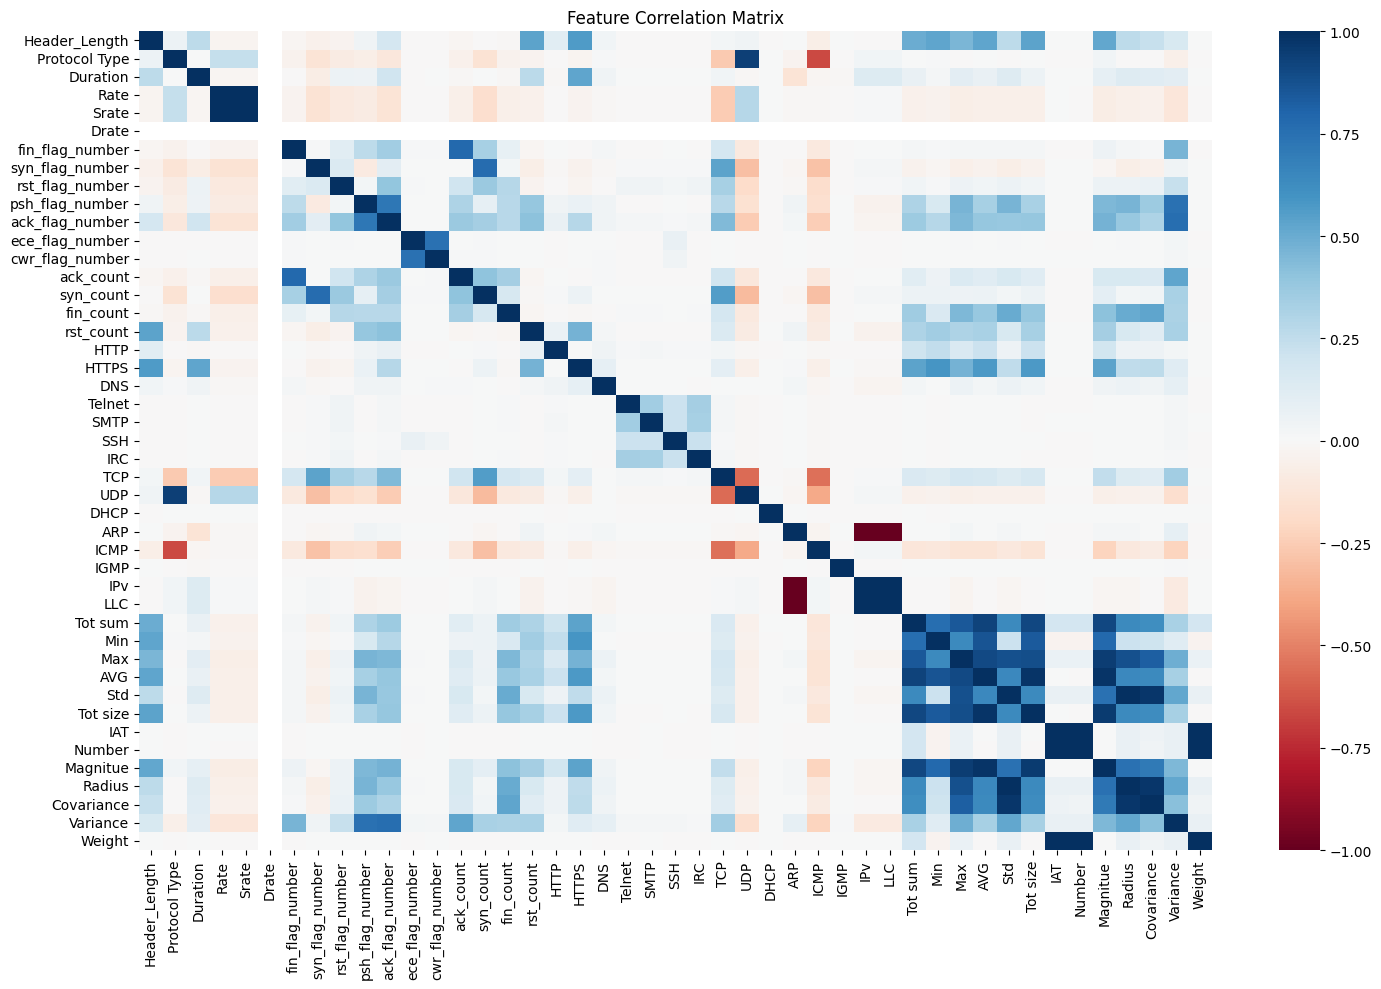


Top 10 High Variance Features:
IAT              4.468442e+14
Header_Length    1.740060e+11
Rate             1.429894e+09
Srate            1.429894e+09
Covariance       8.980780e+08
Tot sum          1.770394e+06
rst_count        2.976720e+05
Max              3.428101e+04
AVG              1.414092e+04
Tot size         1.406991e+04
dtype: float64

Features with >90% correlation:
Protocol Type - UDP: 0.943
Rate - Srate: 1.000
ARP - IPv: -1.000
ARP - LLC: -1.000
IPv - LLC: 1.000
Tot sum - AVG: 0.926
Tot sum - Tot size: 0.910
Tot sum - Magnitue: 0.910
Max - AVG: 0.902
Max - Magnitue: 0.948
AVG - Tot size: 0.977
AVG - Magnitue: 0.979
Std - Radius: 1.000
Std - Covariance: 0.970
Tot size - Magnitue: 0.959
IAT - Number: 0.998
IAT - Weight: 0.999
Number - Weight: 1.000
Radius - Covariance: 0.970

Zero Value Percentages:
Drate              100.000000
IGMP                99.996611
DHCP                99.993117
cwr_flag_number     99.990770
ece_flag_number     99.989050
SMTP                99.93231

In [54]:
def analyze_features(df):
    # Correlation Analysis
    corr = df.corr()
    
    # Feature Variance
    variance = df.var().sort_values(ascending=False)
    
    # Zero Values Percentage
    zero_percent = (df == 0).sum() / len(df) * 100
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, cmap='RdBu', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Return analysis results
    analysis = {
        'correlation': corr,
        'variance': variance,
        'zero_percentage': zero_percent,
    }
    
    return analysis

# Usage
df = pd.read_csv('merged_train.csv')
numeric_df = df.select_dtypes(include=[np.number])
analysis_results = analyze_features(numeric_df)

# Print variance
print("\nTop 10 High Variance Features:")
print(analysis_results['variance'].head(10))

# Print features with high correlation
print("\nFeatures with >90% correlation:")
corr_matrix = analysis_results['correlation']
high_corr = np.where(np.abs(corr_matrix) >= 0.9)
for i, j in zip(*high_corr):
    if i < j:
        print(f"{corr_matrix.index[i]} - {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

# Print features with high zero percentage
print("\nZero Value Percentages:")
print(analysis_results['zero_percentage'].sort_values(ascending=False).head(10))

After this analysis we decided to drop the Drate column given its costant value to 0.

##### Coefficient of Relative Rispersion
The approach we adopted consist in dividing standard deviation by the range. This could be a valid normalization method that expresses variability relative to the total spread of the data, usually used to compare metrics of differents features on different scales.

In [49]:
def compare_variance(df):
   variance = df.var()
   data_range = df.max() - df.min()
   normalized = np.sqrt(variance) / data_range
   
   comparison = pd.DataFrame({
       'Raw_Variance': variance,
       'Normalized_Variance': normalized
   }).sort_values('Normalized_Variance', ascending=False)
   
   return comparison

numeric_df = df.select_dtypes(include=[np.number])
variance_comparison = compare_variance(numeric_df)
print("Variance Comparison:")
print(variance_comparison)

Variance Comparison:
                 Raw_Variance  Normalized_Variance
TCP              2.444515e-01             0.494420
UDP              1.994568e-01             0.446606
ICMP             1.926303e-01             0.438897
Protocol Type    3.709022e+01             0.358246
syn_flag_number  1.180743e-01             0.343619
ack_flag_number  7.894070e-02             0.280964
Variance         6.748757e-02             0.259784
rst_flag_number  2.368890e-02             0.153912
Max              3.428101e+04             0.125782
IAT              4.468442e+14             0.124735
psh_flag_number  1.276598e-02             0.112987
Weight           6.606978e+02             0.105517
Magnitue         1.843399e+01             0.093617
HTTPS            6.833817e-03             0.082667
AVG              1.414092e+04             0.080785
Tot size         1.406991e+04             0.080582
Std              3.129814e+03             0.077577
Radius           6.254578e+03             0.077518
Number    

After some resoning we decided to drop the following columns:

In [56]:
to_drop = ["Srate", "Protocol Type", "IPv", "LLC", "Tot sum", "Tot size", "AVG", "Max", "Number", "Weight"]
#df = df.drop(columns=to_drop)